In [109]:
import shap
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from evolutionary_algorithm import EvolutionaryAlgorithm

In [111]:
class EvolutionaryAlgorithm:
    def __init__(self, data):
        self.data = data
        # Clean numeric columns by removing commas and converting to float
        for column in self.data.columns:
            try:
                self.data[column] = self.data[column].str.replace(',', '').astype(float)
            except (AttributeError, ValueError):
                # If conversion fails, column might already be numeric or non-numeric
                continue

    def objective_function(self, individual):
        try:
            co2_emissions = float(individual['Energy Related CO2missions (Gigatonnes)'])
            electricity_generation = float(individual['Electricity Generation (Terawatt-hours)'])
            fitness = -co2_emissions + 0.5 * electricity_generation
            return fitness
        except (ValueError, KeyError) as e:
            print(f"Error in objective function: {e}")
            print(f"Individual data: {individual}")
            return float('-inf')  # Return worst possible fitness if there's an error

    def initialize_population(self, population_size):
        """
        Initialize a population of individuals (rows from the dataset).
        Each individual is a row of the dataset.
        """
        population = []
        for _ in range(population_size):
            individual = self.data.sample().squeeze().to_dict()  # Convert to dictionary for easier handling
            population.append(individual)
        return population

    def selection(self, population, fitness_scores):
        """
        Select the top half of the population based on fitness scores.
        """
        population_fitness = list(zip(fitness_scores, population))
        population_fitness.sort(reverse=True, key=lambda x: x[0])
        selected = [ind for score, ind in population_fitness[:len(population)//2]]
        return selected

    def crossover(self, parent1, parent2):
        """
        Perform crossover by mixing features of two parents to create a child.
        """
        child = {}
        for key in parent1.keys():
            if random.random() < 0.5:
                child[key] = parent1[key]
            else:
                child[key] = parent2[key]
        return child

    def mutate(self, individual, mutation_rate):
        """
        Mutate an individual's features slightly, to introduce variation.
        """
        mutated = individual.copy()
        for key in mutated.keys():
            if random.random() < mutation_rate:
                # Only mutate if the value is numeric
                try:
                    min_val = float(self.data[key].min())
                    max_val = float(self.data[key].max())
                    mutated[key] = random.uniform(min_val, max_val)
                except (ValueError, TypeError):
                    continue
        return mutated

    def run(self):
        population_size = 50
        generations = 100
        mutation_rate = 0.1

        # Initialize population
        population = self.initialize_population(population_size)
        
        best_fitness_history = []
        avg_fitness_history = []

        for generation in range(generations):
            # Evaluate fitness
            fitness_scores = [self.objective_function(individual) for individual in population]
            
            # Track statistics
            best_fitness = max(fitness_scores)
            avg_fitness = sum(fitness_scores) / len(fitness_scores)
            best_fitness_history.append(best_fitness)
            avg_fitness_history.append(avg_fitness)
            
            print(f"Generation {generation + 1}")
            print(f"Best Fitness: {best_fitness:.2f}")
            print(f"Average Fitness: {avg_fitness:.2f}")
            print("-" * 40)

            # Selection
            selected_population = self.selection(population, fitness_scores)

            # Crossover and mutation
            new_population = []
            while len(new_population) < population_size:
                parent1, parent2 = random.sample(selected_population, 2)
                child = self.crossover(parent1, parent2)
                child = self.mutate(child, mutation_rate)
                new_population.append(child)

            population = new_population

        print("\nEvolution complete!")
        print(f"Final Best Fitness: {max(fitness_scores):.2f}")
        return best_fitness_history, avg_fitness_history

In [112]:
# Load the final cleaned dataset
final_merged_df = pd.read_csv('scaled_merged_dataset.csv') 

In [113]:
# Initialize the evolutionary algorithm with the data
ea = EvolutionaryAlgorithm(data=final_merged_df)

In [115]:
# Run the evolutionary algorithm
best_fitness_history, avg_fitness_history = ea.run()

Generation 1
Best Fitness: 12810.75
Average Fitness: 10189.13
----------------------------------------
Generation 2
Best Fitness: 12812.91
Average Fitness: 11427.21
----------------------------------------
Generation 3
Best Fitness: 12812.91
Average Fitness: 12039.25
----------------------------------------
Generation 4
Best Fitness: 12812.44
Average Fitness: 12045.38
----------------------------------------
Generation 5
Best Fitness: 12812.44
Average Fitness: 12401.18
----------------------------------------
Generation 6
Best Fitness: 12812.60
Average Fitness: 12264.17
----------------------------------------
Generation 7
Best Fitness: 12812.75
Average Fitness: 12811.44
----------------------------------------
Generation 8
Best Fitness: 12812.76
Average Fitness: 12453.20
----------------------------------------
Generation 9
Best Fitness: 12812.76
Average Fitness: 12724.33
----------------------------------------
Generation 10
Best Fitness: 12813.61
Average Fitness: 12595.04
----------

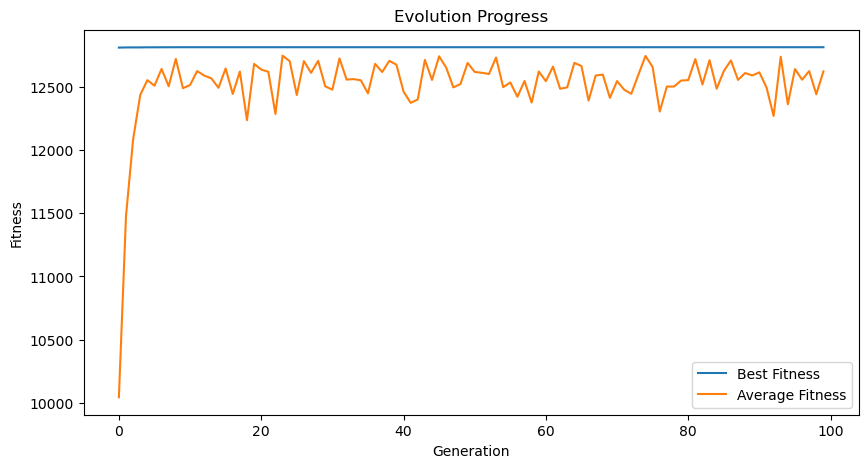

In [110]:
plt.figure(figsize=(10, 5))
plt.plot(best_fitness_history, label='Best Fitness')
plt.plot(avg_fitness_history, label='Average Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Evolution Progress')
plt.legend()
plt.show()